In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommender import MainRecommender

from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

val_lvl_1_size_weeks = 6 # Промежуток для валидации модели первого уровня
val_lvl_2_size_weeks = 3 # Промежуток для валидация модели второго уровня

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


## Префильтрация items, чтобы отсеять то что мы не собираемся рекомендовать

In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()
n_users_before = data_train_lvl_1['user_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
n_users_after = data_train_lvl_1['user_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))
print('Decreased # users from {} to {}'.format(n_users_before, n_users_after))

Decreased # items from 83685 to 5001
Decreased # users from 2498 to 2496


In [4]:
data_train_lvl_1.sample(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
54740,39,27661396857,57,825665,1,2.00,320,-1.39,1817,9,0.0,0.0,2.00
762632,895,30857077254,258,866211,1,2.89,442,0.00,1920,38,0.0,0.0,2.89
1165854,2344,32231860281,358,999999,1,2.69,410,-0.90,1039,52,0.0,0.0,2.69


In [5]:
recommender = MainRecommender(data_train_lvl_1)

C:\Users\David\anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [6]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
print(result_lvl_1.shape)

result_lvl_1.head(2)

(2154, 2)


,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


##  Выбор модели

In [7]:
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))

In [8]:
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [9]:
result_lvl_1['sim_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))

In [10]:
result_lvl_1['sim_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [11]:
def count_metric_at_k(result_lvl_1, metric='recall', N=[10, 20, 50]):
    metrics = {'als': [], 'own': [], 'sim_items': [], 'sim_users': []}
    for n in N:
        als = result_lvl_1.apply(lambda row: recall_at_k(row['als'], row['actual'], k=n), axis=1).mean()
        own = result_lvl_1.apply(lambda row: recall_at_k(row['own'], row['actual'], k=n), axis=1).mean()
        sim_it = result_lvl_1.apply(lambda row: recall_at_k(row['sim_items'], row['actual'], k=n), axis=1).mean()
        sim_users = result_lvl_1.apply(lambda row: recall_at_k(row['sim_users'], row['actual'], k=n), axis=1).mean()
        metrics['als'].append(round(als, 3))
        metrics['own'].append(round(own, 3))
        metrics['sim_items'].append(round(sim_it, 3))
        metrics['sim_users'].append(round(sim_users, 3))
    return metrics

metrics = count_metric_at_k(result_lvl_1)
metrics
        

{'als': [0.034, 0.05, 0.081],
 'own': [0.003, 0.005, 0.025],
 'sim_items': [0.014, 0.024, 0.047],
 'sim_users': [0.025, 0.039, 0.065]}

#### ALS Показывает лучшее качество на валидации

In [12]:
# Подготовка данных для обучения модели 2 уровня
def get_data_for_lvl_2(data_train_lvl_2, data_train_lvl_1, recommender, N=50):
    users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
    users_lvl_2.columns = ['user_id']

    # Пока только warm start
    train_users = data_train_lvl_1['user_id'].unique()
    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

    users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))

    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'

    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    users_lvl_2['flag'] = 1


    targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
    targets_lvl_2['target'] = 1  # тут только покупки 

    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('flag', axis=1, inplace=True)
    return targets_lvl_2

targets_lvl_2 = get_data_for_lvl_2(data_train_lvl_2, data_train_lvl_1, recommender)
targets_lvl_2.head(3)

,user_id,item_id,target
0,2070,1029743,0.0
1,2070,9526410,0.0
2,2070,5569230,0.0


In [13]:
# Добавляем фичи пользователей и итемов
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,9526410,0.0,544,GROCERY,National,BAG SNACKS,POTATO CHIPS,11.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [14]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [15]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats, random_state=42)
lgb.fit(X_train, y_train)

probs = lgb.predict_proba(X_train)[:, 1]

print(f"Train roc_auc = {roc_auc_score(y_train, probs)}")

C:\Users\David\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\David\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\David\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Train roc_auc = 0.8254035114416073


In [16]:
targets_lvl_2 = get_data_for_lvl_2(data_val_lvl_2, data_train_lvl_1, recommender, N=50)
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,338,845208,0.0,69,PRODUCE,Private,ONIONS,ONIONS YELLOW (BULK&BAG),3 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,338,896613,0.0,4308,MEAT,National,CHICKEN,WHOLE CHICKEN (ROASTERS/FRYER),,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
X_val = targets_lvl_2.drop('target', axis=1)
X_val[cat_feats] = X_val[cat_feats].astype('category')
y_val = targets_lvl_2[['target']]

val_preds = lgb.predict_proba(X_val)[:, 1]

In [18]:
print(f"Val roc_auc = {roc_auc_score(y_val, val_preds)}")

Val roc_auc = 0.753374777796002


In [19]:
# Ранжируем по вероятностям целевого класса
X_val['probs'] = val_preds

candidates = []
user_id = []
for user in X_val['user_id'].unique():
    candidates_for_user = X_val[X_val['user_id'] == user].sort_values("probs", ascending=False).iloc[:10, 1].values
    candidates.append(candidates_for_user)
    user_id.append(user)

result_train_lvl_2 = pd.DataFrame({'user_id': user_id, 'lgb': candidates})

result_train_lvl_2['candidates'] = result_train_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=10))

In [20]:
result_train_lvl_2.sample(3)

,user_id,lgb,candidates
1361,1459,"[1029743, 1106523, 995242, 995242, 951590, 104...","[951590, 885290, 995876, 965766, 832678, 84417..."
966,2442,"[1126899, 953539, 916122, 961554, 976199, 9132...","[1126899, 5569845, 1127831, 940947, 5568489, 8..."
358,779,"[1029743, 995242, 1126899, 1070820, 1057260, 1...","[5569230, 5569471, 1057260, 872137, 976199, 85..."


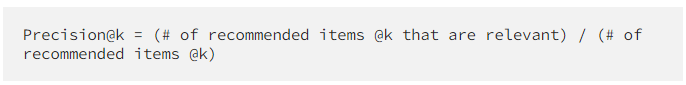

In [21]:
result_train_lvl_2.apply(lambda row: precision_at_k(row['lgb'], row['candidates'], k=10), axis=1).mean()

0.31397058823529234

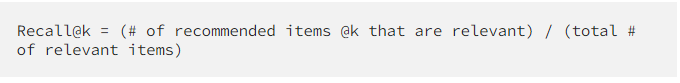

In [22]:
result_train_lvl_2.apply(lambda row: recall_at_k(row['lgb'], row['candidates'], k=10), axis=1).mean()

0.35382352941176304